In [ ]:
# Mount Google Drive (if necessary)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

DIRECTORY = r"/content/drive/MyDrive/data5"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [ ]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Load the pre-trained DenseNet121 model
baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Combine the base model and the head model
model = Model(inputs=baseModel.input, outputs=headModel)


# Print the model summary
model.summary()

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
import tensorflow as tf
# compile our model
print("[INFO] compiling model...")

opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
72/72 [==============================] - 58s 579ms/step - loss: 0.4976 - accuracy: 0.8103 - val_loss: 0.1895 - val_accuracy: 0.9897
Epoch 2/50
72/72 [==============================] - 29s 396ms/step - loss: 0.2200 - accuracy: 0.9537 - val_loss: 0.0909 - val_accuracy: 0.9983
Epoch 3/50
72/72 [==============================] - 30s 413ms/step - loss: 0.1397 - accuracy: 0.9725 - val_loss: 0.0528 - val_accuracy: 0.9983
Epoch 4/50
72/72 [==============================] - 29s 405ms/step - loss: 0.1021 - accuracy: 0.9799 - val_loss: 0.0377 - val_accuracy: 0.9983
Epoch 5/50
72/72 [==============================] - 29s 401ms/step - loss: 0.0735 - accuracy: 0.9873 - val_loss: 0.0289 - val_accuracy: 0.9983
Epoch 6/50
72/72 [==============================] - 29s 408ms/step - loss: 0.0587 - accuracy: 0.9921 - val_loss: 0.0258 - val_accuracy: 0.9983
Epoch 7/50
72/72 [==============================] - 29s 405ms/step - loss: 0.0513 - accuracy: 0.9918 - val_loss: 0.0197 - val_accuracy: 0.9983

In [ ]:
loss, accuracy = model.evaluate(testX, testY)
print('Test Accuracy =', accuracy)

19/19 [==============================] - 3s 158ms/step - loss: 0.0037 - accuracy: 0.9983
Test Accuracy = 0.998275876045227


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/drive/MyDrive/model/Dense121_mask_detector.h5")

[INFO] evaluating network...
19/19 [==============================] - 4s 87ms/step
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       320
without_mask       1.00      1.00      1.00       260

    accuracy                           1.00       580
   macro avg       1.00      1.00      1.00       580
weighted avg       1.00      1.00      1.00       580

[INFO] saving mask detector model...


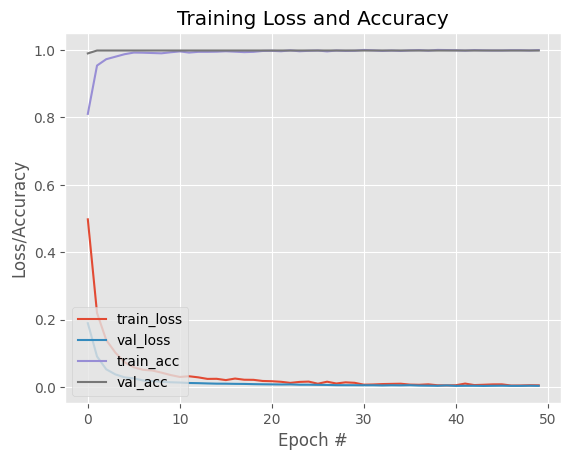

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

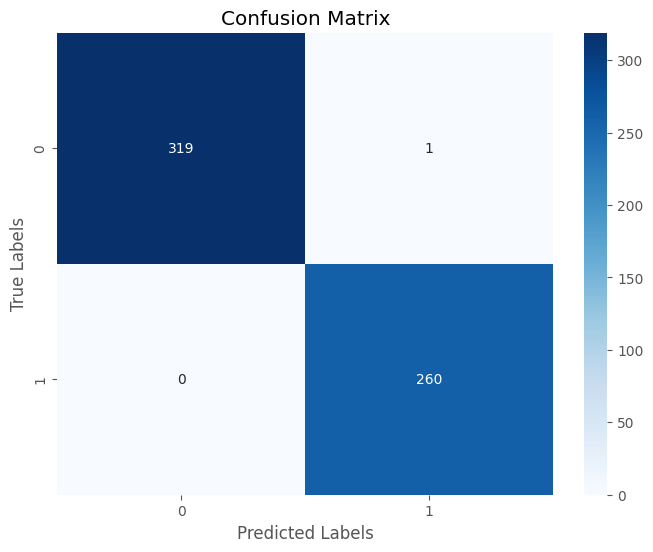

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# compute the confusion matrix
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()